# Import packages

In [135]:
# Import packages

import pandas as pd
import numpy as np
from scipy.io import arff
import math
from collections import Counter
from numpy import argmax
import dataframe_image as dfi

# Modeling & Model Performance Evaluation
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

# Missing values imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

# SHAP
import IPython
import shap

#### Specification of columnnames:

In [136]:

Attr_Dict = {
"Attr1" :	"net profit / total assets",
"Attr2" :	"total liabilities / total assets" ,
"Attr3" :	"working capital / total assets" ,
"Attr4" :	"current assets / short-term liabilities",
"Attr5" :	"((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365" ,
"Attr6" :	"retained earnings / total assets" ,
"Attr7" :	"EBIT / total assets" ,
"Attr8" :	"book value of equity / total liabilities" ,
"Attr9" :	"sales / total assets" ,
"Attr10" :	"equity / total assets" ,
"Attr11" :	"(gross profit + extraordinary items + financial expenses) / total assets",
"Attr12" :	"gross profit / short-term liabilities" ,
"Attr13" :	"(gross profit + depreciation) / sales" ,
"Attr14" :	"(gross profit + interest) / total assets" ,
"Attr15" :	"(total liabilities * 365) / (gross profit + depreciation)" ,
"Attr16" :	"(gross profit + depreciation) / total liabilities" ,
"Attr17" :	"total assets / total liabilities" ,
"Attr18" :	"gross profit / total assets",
"Attr19" :	"gross profit / sales" ,
"Attr20" :	"(inventory * 365) / sales" ,
"Attr21" :	"sales (n) / sales (n-1)" ,
"Attr22" :	"profit on operating activities / total assets" ,
"Attr23" :	"net profit / sales" ,
"Attr24" :	"gross profit (in 3 years) / total assets" ,
"Attr25" :	"(equity - share capital) / total assets" ,
"Attr26" :	"(net profit + depreciation) / total liabilities" ,
"Attr27" :	"profit on operating activities / financial expenses" ,
"Attr28" :	"working capital / fixed assets",
"Attr29" :	"logarithm of total assets" ,
"Attr30" :	"(total liabilities - cash) / sales" ,
"Attr31" :	"(gross profit + interest) / sales" ,
"Attr32" :	"(current liabilities * 365) / cost of products sold" ,
"Attr33" :	"operating expenses / short-term liabilities" ,
"Attr34" :	"operating expenses / total liabilities" ,
"Attr35" :	"profit on sales / total assets" ,
"Attr36" :	"total sales / total assets" ,
"Attr37" :	"(current assets - inventories) / long-term liabilities" ,
"Attr38" :	"constant capital / total assets" ,
"Attr39" :	"profit on sales / sales" ,
"Attr40" :	"(current assets - inventory - receivables) / short-term liabilities" ,
"Attr41" :	"total liabilities / ((profit on operating activities + depreciation) * (12/365))" ,
"Attr42" :	"profit on operating activities / sales" ,
"Attr43" :	"rotation receivables + inventory turnover in days" ,
"Attr44" :	"(receivables * 365) / sales" ,
"Attr45" :	"net profit / inventory" ,
"Attr46" :	"(current assets - inventory) / short-term liabilities",
"Attr47" :	"(inventory * 365) / cost of products sold" ,
"Attr48" :	"EBITDA (profit on operating activities - depreciation) / total assets" ,
"Attr49" :	"EBITDA (profit on operating activities - depreciation) / sales" ,
"Attr50" :	"current assets / total liabilities" ,
"Attr51" :	"short-term liabilities / total assets" ,
"Attr52" :	"(short-term liabilities * 365) / cost of products sold)" ,
"Attr53" :	"equity / fixed assets" ,
"Attr54" :	"constant capital / fixed assets" ,
"Attr55" :	"working capital",
"Attr56" :	"(sales - cost of products sold) / sales" ,
"Attr57" :	"(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)" ,
"Attr58" :	"total costs /total sales" ,
"Attr59" :	"long-term liabilities / equity" ,
"Attr60" :	"sales / inventory" ,
"Attr61" :	"sales / receivables" ,
"Attr62" :	"(short-term liabilities *365) / sales" ,
"Attr63" :	"sales / short-term liabilities" ,
"Attr64" :	"sales / fixed assets"}


# Functions

In [137]:
# Function to rename the attributes columns to their actual names.
def rename_attributes(df):
    """ Rename columns of a dataframe according to specification in the dictionary: Attr_Dict"""
    for i in range (1,65):
        col_name = "Attr" + str(i)
        df.rename(columns={col_name: Attr_Dict.get(col_name)}, inplace= True)


# Convert bankruptcy column to binary numeric format (0/1)
def make_class_binary(df):
    """Make class numerical and rename the feature"""
    df["class"] = pd.to_numeric(df["class"])
    df.rename(columns={"class": "Bankruptcy Dummy"}, inplace= True)


# Function to use multivariate feature imputation for imputation of missing values.
def multivariate_feature_imputation(df):
    """
    Objective:  Modeling each feature with missing values as a function of other features, and uses that estimate for imputation.
                At each step, a feature is the dependent variable (DV) and the other features are treated as independent variables.
                A model is fit on those input & output variables for known DV values. Then, the model is used to predict the missing values of the DV. 
                This is done for each feature iteratively.

    Input:      df: Imported & processed dataframe, e.g. "data_year_1"

    Output:     The input dataframe with imputed missing values, that is, without remaining missing values.
    
    """

    imp = IterativeImputer(random_state=117)
    # Fit the imputer on X and return the transformed X
    imputed = imp.fit_transform(df)
    result_df = pd.DataFrame(imputed, columns=df.columns)
    return result_df

def drop_duplicate_rows(df):
    """ Drop duplicate rows and print the number of deleted rows. """
    num_dupl = df.duplicated(keep='first').sum()
    print(f"Number of removed duplicates: {num_dupl}")
    df.drop_duplicates(inplace = True)

def analyze_missing_values(data, n_display = 10):
    """
    Objective:  Calculate & plot the percentage of missing values per feature in the dataset.

    Input:      data: Imported & processed dataframe, e.g. "data_year_1"
                n_display: Determines how many variables with the highest % of missing values should be plotted. 

    Output:     (Sorted) List of variables and their respective % of missing values + bar chart.
    
    """
    
    # Calculate % of missing values
    Missing = pd.DataFrame(round(data.isnull().sum()*100/len(data),2))
    Missing.columns =['Percentage_missing_values'] 
    Missing['Features'] = Missing.index
    Missing1 = Missing.sort_values("Percentage_missing_values", ascending=False).iloc[0:n_display ,:]
    
    # define the color palette of different colors
    pal = sns.color_palette("summer", len(Missing1))
    # use argsort method to create a rank for the palette
    rank = Missing1["Percentage_missing_values"].argsort()

    # Plot n_display variables with highest missing value proportions
    ax = sns.barplot(x="Percentage_missing_values", y="Features", data=Missing1,
                label="Total", palette= np.array(pal[::-1])[rank])

    # Show percenatge values in bar chart
    for i in ax.containers:
        ax.bar_label(i,)

    plt.show()
    # Return missing values proportions of all features
    return Missing.sort_values("Percentage_missing_values", ascending=False).reset_index(drop=True)

def calc_attr_46(data):
    """
    Objective:  Attribute 46 has a lot of NA's. This function tries to derive those missing values based on the other metrics in the dataset.
                First derive total_assets by taking: e^(logarithm of total assets).
                We can use total_assets to calculate many standalone metrics, in the first place: equity. Using equity we can derive long_term_liabilities etc.

    Input:      data: Imported & processed dataframe, e.g. "data_year_1"

    Output:     Following features: total_assets,
                                    equity,
                                    long_term_liabilities,
                                    short_term_liabilities,
                                    (current assets - inventory),
                                    (current assets - inventories) / long-term liabilities new <--- This is the newly calculated attribute 46

    """
    n_missing_before = data["(current assets - inventories) / long-term liabilities"].isna().sum()
    
    #Calculate total assets
    data["total_assets"] = data["logarithm of total assets"].apply(lambda x: math.exp(x))
    
    # Calculate equity
    data["equity"] = data["total_assets"] * data ["equity / total assets"]

    # Calculate long-term liabilities
    data["long_term_liabilities"] = data["long-term liabilities / equity"] * data["equity"]

    # calculate short term liabilities
    data["short_term_liabilities"] = data["short-term liabilities / total assets"] * data["total_assets"]

    # Calculate "(current assets - inventory)"
    data["(current assets - inventory)"] = data["(current assets - inventory) / short-term liabilities"] * data["short_term_liabilities"] 

    # Finally, calculate the desired column, which contains many NA's
    data["(current assets - inventories) / long-term liabilities new"] = data["(current assets - inventory)"] / data["long_term_liabilities"] 

    n_missing_after = data["(current assets - inventories) / long-term liabilities new"].isna().sum()
    
    print(f"Number of missing values before new calculation: {n_missing_before} \ Number of missing values after new calculation: {n_missing_after}")
    

def replace_na_s_in_attr46(df):
    """
    Objective:  Replace NA's of attribute 46 where long_term_liabilities == 0 and delete the newly created columns that are no longer required.
                Explanation: I tried to calculate attribute 46 (with a lot of missing values) by myself by deriving the individual values from formulas. 
                Then I realized that the number of NA's was significatly smaller: 
                NA's before new calculation: 2709 
                NA's after new calculation: 31
                BUT: The NA's are now Inf's. Then I digged deeper why this is the case. The problem is the denominator long_term_liabilities which is zero, see output below.
                long_term_liabilities represent all  payables & obligations in a period of 12 months and longer. Therefore we can assume, that if 
                "(current assets - inventories) / long-term liabilities" is not available, that the company does not have long-term-liabilities. 
                Therefore I will set this variable to 0, where long_term_liabilities=0.
    
    Input:      data: Imported & processed dataframe, e.g. "data_year_1"
    
    Output:     Input Dataframe with replaced NA's in the "(current assets - inventories) / long-term liabilities" feature by zero.
    """

    df["(current assets - inventories) / long-term liabilities"] = np.where(df['long_term_liabilities'] == 0, 0, df["(current assets - inventories) / long-term liabilities"])
    
    print_df = df.loc[:, ["(current assets - inventories) / long-term liabilities", "long_term_liabilities"]]
    print("After replacing NA's:", "\n" , print_df.head(5))
      
    df.drop(['total_assets', 'equity', 'long_term_liabilities', 'short_term_liabilities', '(current assets - inventory)', '(current assets - inventories) / long-term liabilities new'], axis=1, inplace = True)


def trim_outlier(df, lower_percentile= 0.01, upper_percentile = 0.98):
    """
    Objective:  Low effort solution, as the focus of this analysis will be on tree-based algorithms that are not prone to outliers. 
                This transformation implies that the max. value of the variable is equal to upper_percentile. Likewise, the smallest 
                possible value is equal to lower_percentile.
    
    Input:      df: Imported & processed dataframe, e.g. "data_year_1"
                lower_percentile: Every velue below the specified lower percentile will be trimmed to the lower percentile value.
                upper_percentile: Every velue above the specified upper percentile will be trimmed to the upper percentile value.

    Output:     The result is a transformed input dataframe, where the outliers are trimmed to the specified boundaries.
    """

    # Select numeric columns
    num_col = df.select_dtypes(include=['int64','float64']).columns.tolist()
    # Trim feature values
    df[num_col] = df[num_col].apply(lambda x: x.clip(*x.quantile([lower_percentile, upper_percentile])))


def VIF(df):
    """
    Objective:  Calculation of the Variance Inflation factor (VIF) = 1 / (1- R^2).
                For this purpose we will use an basic OLS model and estimate VIF.
                This function will be used to remove features with a high multicollinearity.

                Multicollinearity may not interfere with model performance, but it does negatively impact the 
                interpretation of the predictors used to build the model. Important for this case.

    Input:      df: Imported & processed dataframe, e.g. "data_year_1"

    Output:     Dataframe with features and their corresponding VIF.
    """
    # Independent Variables
    X = df.loc[:, df.columns != "Bankruptcy Dummy"]
    # Dependet Variable
    Y = df.loc[:, df.columns == "Bankruptcy Dummy"]
    # Random Seed

    random_seed = 117
    # Specification of the size of the test set
    test_size = 0.33

    # Split data
    # stratify = Y means that the proportions of the dependent variable are kept constant after the split.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size=test_size, random_state=random_seed)

    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    # Y_pred = model.predict(sm.add_constant(X_test))

    x_temp = sm.add_constant(X_train)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
    vif["features"] = x_temp.columns
    result= vif.round(1).sort_values("VIF Factor", ascending= False)
    return result


def remove_cols_with_high_VIF(data, vif_threshold = 8, print_values= False):
    """ 
    Objective: Reduce issue of multicollinearity by applying the variance inflation factor (VIF) function.
    Variables with a VIF > vif_threshold are removed from modeling (at least in linear models, in tree-based model I will try both).
    
    Input:  data: Imported & processed dataframe, e.g. "data_year_1"
            vif_threshold: Acceptance threshold for VIF. Default < 8.

    Output: Returns features that should be kept in the modeling phase, as they have no high multicollinearity between them.
    """
    drop_columns_list = []
    vif_df = VIF(df = data)

    while vif_df.iloc[0,:][0] > vif_threshold or vif_df.iloc[0,:][0] ==  math.inf:
        if (vif_df.iloc[0,:][1] == "const") & (vif_df.iloc[1,:][0] > vif_threshold):
            drop_columns_list.append(vif_df.iloc[1,:][1])
            if print_values == True:
                print(f"Feature {vif_df.iloc[1,:][1]} has a VIF higher than {vif_threshold} and will be dropped.")
        else:
            if (vif_df.iloc[0,:][1] == "const"):
                break
            else:
                drop_columns_list.append(vif_df.iloc[0,:][1])
                if print_values == True:
                    print(f"Feature {vif_df.iloc[0,:][1]} has a VIF higher than {vif_threshold} and will be dropped.")
        vif_df = VIF(df = data.drop(drop_columns_list, axis =1 ))
    # remove 'const' variable as no longer needed.
    vif_df = vif_df[vif_df.features != "const"]
    # Return features that should remain for modeling
    return vif_df["features"]

# Functions for the modeling step
##### Create Model Function

In [138]:
def create_model(df, model_type = XGBClassifier(seed=123), model_label = "XGBoost", XGBoostHyperParamTuning = False, tuned_params = True, Smote = True, sampling_prop = 0.2, plot_results  = True, return_all = True, plot_shap_summary=True):
    """
    Objective: Prepare data for modeling. Split data in test-train datasets.
    Create a model based on certain specifications, e.g. applying smote sampling technique with certain proportions; 
    hyperparameter tuning; get different evaluation metrics like precision, recall, f1-score; plot results;

    Input:  df: Imported & processed dataframe, e.g. "data_year_1"

            model_type: Type of the classification model. Default XGBClassifier().
            
            model_label: Label of the respective model.

            XGBoostHyperParamTuning: If True, hyperparameter tuning will be performed. If False, the previously calculated optimal hyper
            parameter will be used manually (to save time).

            tuned_params: If True, tuned parameters will be used, otherwise default parameters will be used.

            Smote: If True, Smote sampling technique will be used to rebalance the DV classes.

            sampling_prop: Defines to which proportion the (DV = 1) class should be oversampled.

            plot_results: If True, precision-recall curves are plotted for each model. + Confusion Matrix.

            return_all: Return all relevant values that are generated by this function, see Output

            plot_shap_summary: If True, shap summary plot will be plotted.

    Output: Validation set predictions, precision value for max F1-score, recall value for max F1-score, validation set DV, predictions, max. f1-score,
            precision values for all thresholds, recall values for all thresholds.
    """
    
    # Independent Variables
    X = df.loc[:, df.columns != "Bankruptcy Dummy"]
    # Dependent Variable
    Y = df.loc[:, df.columns == "Bankruptcy Dummy"]

    # Random Seed
    random_seed = 117
    # Specification of the size of the test set
    test_size = 0.33

    # Split data
    # stratify = Y means that the proportions of the dependent variable are kept constant after the split.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size=test_size, random_state=random_seed)

    if Smote == True:
        # Oversample the minority class using the Synthetic Minority Oversampling Technique (SMOTE)
        # sampling_strategy=0.2 means that obersampling is done in a fashion that the DV = 1 represents 20% of the data.
        oversample = SMOTE(sampling_strategy=sampling_prop, random_state = 123) 

        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if XGBoostHyperParamTuning == True:
        # Use grid search method for hyperparameter tuning
        model = XGBClassifier(n_estimators=100, seed= random_seed)
        PARAMETERS = {"subsample":[0.5, 0.75, 1],
                "colsample_bytree":[0.5, 0.75, 1],
                "max_depth":[2, 6, 12],
                "min_child_weight":[1,5,15],
                "learning_rate":[0.3, 0.1, 0.03],
                "n_estimators":[100]}

        eval_set = [(X_test, y_test)]
        model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=5,scoring="f1")
        model_gs.fit(X_train,y_train,early_stopping_rounds=10, eval_metric="error",eval_set=eval_set,verbose=True)
        best_grid = model_gs.best_params_
        print(model_gs.best_params_)

    if tuned_params == True:
        # To save some time, best_grid contains the calculated optimal hyper parameters.
        best_grid = {'objective':'binary:logistic', 'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
        model = model_type
        model.set_params(**best_grid)
        model.fit(X_train, y_train)      
        # Result: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
    else:
        model = model_type
        model.fit(X_train, y_train)

    # make predictions for test data (Probabilities)
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:, 1]
    
    # Calculate precision, recall for all possible thresholds
    precision, recall, thresholds  = precision_recall_curve(y_test, y_pred)
    
    # Maximize f-score, in order to find the best threshold. F-Score is a balance between recall & precision.
    # Calculate f-score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall= %.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix] ))

    # Round predictions based on the optimal calculated threshold:
    predictions = [1 if value > thresholds[ix] else 0 for value in y_pred]
    # Calculate auc score
    auc_score = auc(recall, precision)
    print(f'Model: {model_label}, AUC: {auc_score}')
    print(f"Predictions overview: No bankruptcy: {Counter(predictions)[0]} bankruptcy: {Counter(predictions)[1]}")
    # calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    if plot_results  == True:
        # plot the precision-recall curves
        pyplot.plot(recall, precision, marker='.', label=model_label)
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best_Threshold')

        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()

        # Plot Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, predictions)
        plt.show()

    if plot_shap_summary == True:
        # Create Shap summary plot
        explainer = shap.TreeExplainer(model, feature_perturbation="interventional", model_output = "probability", data=shap.sample(X_test,200))
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

    # Return values
    if return_all == True:
        return y_pred, precision[ix], recall[ix], y_test, predictions, fscore[ix], precision, recall

##### Select best model function

In [139]:
# Create function which runs 6 different models and selects the best one (based on F1-Score). This function will be applied to all 5 datasets.
def select_best_model(data):

    """
    Objective: This function runs 6 different models and selects the best one (based on F1-Score). This function will be applied to all 5 datasets.

    Input:  Imported & processed dataframe, e.g. "data_year_1"

    Output: Metrics to all performed models: Precision, Recall & F1-Score. + The best model. This information can be used to apply the best models to the respective datasets.
    """

    # Model: Smote 20%; Hyperparameter tuned; XGBoost
    y_pred_xgb_tuned_smote20, precision_xgb_tuned_smote20, recall_xgb_tuned_smote20, y_test_xgb_tuned_smote20, predictions_xgb_tuned_smote20, f1_xgb_tuned_smote20, precision_all_xgb_tuned_smote20, recall_all_xgb_tuned_smote20= create_model(
        df = data, Smote = True, sampling_prop= 0.20, plot_results = False, plot_shap_summary = False)

    # Model: Smote 30%; Hyperparameter tuned; XGBoost
    y_pred_xgb_tuned_smote30, precision_xgb_tuned_smote30, recall_xgb_tuned_smote30, y_test_xgb_tuned_smote30, predictions_xgb_tuned_smote30, f1_xgb_tuned_smote30, precision_all_xgb_tuned_smote30, recall_all_xgb_tuned_smote30 = create_model(
    df = data, Smote = True, sampling_prop= 0.30, plot_results = False, plot_shap_summary = False)

    # Model: Smote 40%; Hyperparameter tuned; XGBoost 
    y_pred_xgb_tuned_smote40, precision_xgb_tuned_smote40, recall_xgb_tuned_smote40, y_test_xgb_tuned_smote40, predictions_xgb_tuned_smote40, f1_xgb_tuned_smote40, precision_all_xgb_tuned_smote40, recall_all_xgb_tuned_smote40 = create_model(
    df = data, Smote = True, sampling_prop= 0.40, plot_results = False, plot_shap_summary = False)

    # Model: Smote 50%; Hyperparameter tuned; XGBoost
    y_pred_xgb_tuned_smote50, precision_xgb_tuned_smote50, recall_xgb_tuned_smote50, y_test_xgb_tuned_smote50, predictions_xgb_tuned_smote50, f1_xgb_tuned_smote50, precision_all_xgb_tuned_smote50, recall_all_xgb_tuned_smote50 = create_model(
    df = data, Smote = True, sampling_prop= 0.50, plot_results = False, plot_shap_summary = False)

    # Model: No Smote; Hyperparameter tuned; XGBoost
    y_pred_xgb_tuned, precision_xgb_tuned, recall_xgb_tuned, y_test_xgb_tuned, predictions_xgb_tuned, f1_xgb_tuned, precision_all_xgb_tuned, recall_all_xgb_tuned = create_model(
    df = data, Smote = False, plot_results = False, plot_shap_summary = False)
    
    # Model: No Smote; No Hyperparameter tuning; XGBoost
    y_pred_xgb, precision_xgb, recall_xgb, y_test_xgb, predictions_xgb, f1_xgb, precision_all_xgb, recall_all_xgb = create_model(
    df = data, Smote = False, tuned_params = False, plot_results = False, plot_shap_summary = False)
    
    # Gather metrics
    metrics = {'Model': ["xgb_tuned_smote20","xgb_tuned_smote30", "xgb_tuned_smote40","xgb_tuned_smote50", "xgb_tuned","xgb_untuned"],
        'Precision': [precision_xgb_tuned_smote20, precision_xgb_tuned_smote30, precision_xgb_tuned_smote40, precision_xgb_tuned_smote50, precision_xgb_tuned, precision_xgb],
        'Recall': [recall_xgb_tuned_smote20,recall_xgb_tuned_smote30,recall_xgb_tuned_smote40,recall_xgb_tuned_smote50,recall_xgb_tuned, recall_xgb],
        'F1-Score': [f1_xgb_tuned_smote20,f1_xgb_tuned_smote30,f1_xgb_tuned_smote40,f1_xgb_tuned_smote50, f1_xgb_tuned, f1_xgb]}

    # Create dataframe for the metrics and sort it by F1-Score
    metrics_df = pd.DataFrame(data=metrics)
    best_model = metrics_df.sort_values(["F1-Score", "Precision", "Recall"], ascending = False).iloc[0,0]

    # Plot precision-recall-curves of all models for a certain dataset in one plot
    pyplot.plot(recall_all_xgb_tuned_smote20, precision_all_xgb_tuned_smote20, marker='.', label="xgb_tuned_smote20")
    pyplot.plot(recall_all_xgb_tuned_smote30, precision_all_xgb_tuned_smote30, marker='.', label="xgb_tuned_smote30")
    pyplot.plot(recall_all_xgb_tuned_smote40, precision_all_xgb_tuned_smote40, marker='.', label="xgb_tuned_smote40")
    pyplot.plot(recall_all_xgb_tuned_smote50, precision_all_xgb_tuned_smote50, marker='.', label="xgb_tuned_smote50")
    pyplot.plot(recall_all_xgb_tuned, precision_all_xgb_tuned, marker='.', label="xgb_tuned")
    pyplot.plot(recall_all_xgb, precision_all_xgb, marker='.', label="xgb_untuned")

    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

    # Return metrics dataframe and the best model (string)
    return metrics_df, best_model


# Import Datasets

In [140]:
# Year 1
dataset = arff.loadarff(open(r'/Users/anatoliymakaveyev/Documents/Python Environment/BANKRUPTCY_PREDICTION_CASE/data/1year.arff'))
data_year_1 = pd.DataFrame(dataset[0])

# Year 2
dataset = arff.loadarff(open(r'/Users/anatoliymakaveyev/Documents/Python Environment/BANKRUPTCY_PREDICTION_CASE/data/2year.arff'))
data_year_2 = pd.DataFrame(dataset[0])

# Year 3
dataset = arff.loadarff(open(r'/Users/anatoliymakaveyev/Documents/Python Environment/BANKRUPTCY_PREDICTION_CASE/data/3year.arff'))
data_year_3 = pd.DataFrame(dataset[0])

# Year 4
dataset = arff.loadarff(open(r'/Users/anatoliymakaveyev/Documents/Python Environment/BANKRUPTCY_PREDICTION_CASE/data/4year.arff'))
data_year_4 = pd.DataFrame(dataset[0])

# Year 5
dataset = arff.loadarff(open(r'/Users/anatoliymakaveyev/Documents/Python Environment/BANKRUPTCY_PREDICTION_CASE/data/5year.arff'))
data_year_5 = pd.DataFrame(dataset[0])

data_year_1.head(5)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


#### Apply functions to all dataframes to rename the columns, convert bankruptcy variable to numeric format & remove duplicates


In [141]:
# Create list of all dataframes
df_list= [data_year_1,data_year_2, data_year_3, data_year_4, data_year_5]

# Apply functions
[rename_attributes(df) for df in df_list]
[make_class_binary(df) for df in df_list]

# Remove duplicate rows
[drop_duplicate_rows(df) for df in df_list]

Number of removed duplicates: 82
Number of removed duplicates: 90
Number of removed duplicates: 87
Number of removed duplicates: 82
Number of removed duplicates: 60


[None, None, None, None, None]

#### Check distribution of the dependent variable across the datasets.

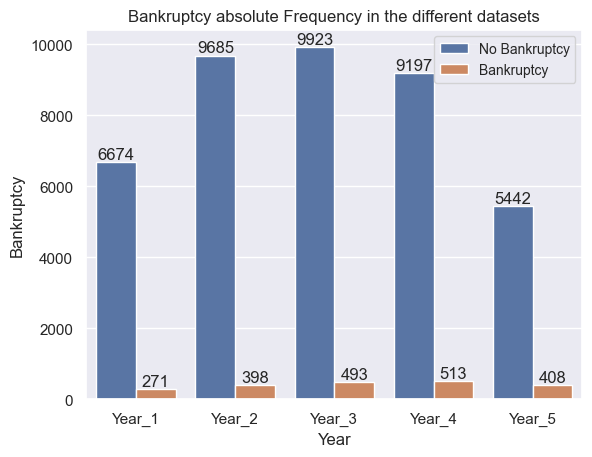

In [142]:
# Create dataframe to plot the result

d = {'Year': ["Year_1","Year_1", "Year_2","Year_2", "Year_3","Year_3", "Year_4","Year_4","Year_5", "Year_5"], 

    'Bankruptcy': [         data_year_1["Bankruptcy Dummy"].value_counts()[0],
                            data_year_1["Bankruptcy Dummy"].value_counts()[1],
                            data_year_2["Bankruptcy Dummy"].value_counts()[0],
                            data_year_2["Bankruptcy Dummy"].value_counts()[1],
                            data_year_3["Bankruptcy Dummy"].value_counts()[0],
                            data_year_3["Bankruptcy Dummy"].value_counts()[1],
                            data_year_4["Bankruptcy Dummy"].value_counts()[0],
                            data_year_4["Bankruptcy Dummy"].value_counts()[1],
                            data_year_5["Bankruptcy Dummy"].value_counts()[0],
                            data_year_5["Bankruptcy Dummy"].value_counts()[1]],
    'Bankruptcy Dummy': ["No Bankruptcy","Bankruptcy", "No Bankruptcy","Bankruptcy", "No Bankruptcy","Bankruptcy", "No Bankruptcy","Bankruptcy","No Bankruptcy","Bankruptcy"]}


df_plot = pd.DataFrame(data=d)
# Calculate proportions of bankruptcy dummy across the years.
df_plot['Bankruptcy (%)'] = df_plot.groupby('Year')['Bankruptcy'].transform(lambda x: round(x / x.sum() * 100, 2))

# Plot the distribution of the dependent variable across the datasets.
sns.set_theme()
ax = sns.barplot(data=df_plot, x="Year", y="Bankruptcy", hue="Bankruptcy Dummy")
plt.title("Bankruptcy absolute Frequency in the different datasets")
ax.legend(fontsize=10)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

#### Plot relative distribution of the dependent variable

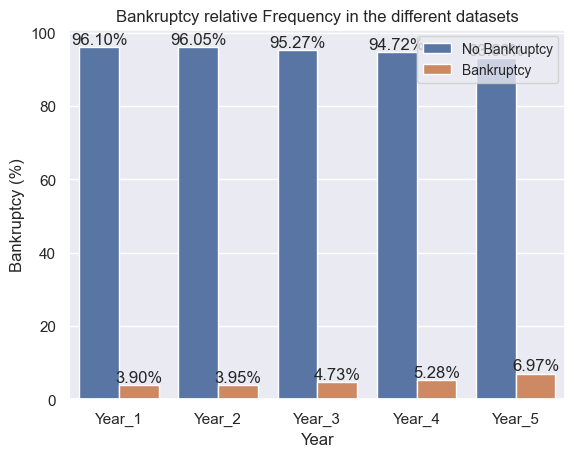

In [143]:
# Plot relative distribution of the dependent variable across the datasets
ax = sns.barplot(data=df_plot, x="Year", y="Bankruptcy (%)", hue="Bankruptcy Dummy")
plt.title("Bankruptcy relative Frequency in the different datasets")
ax.legend(fontsize=10)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')
plt.show()

<p> NOTE: The longer the horizon, the higher the bankuptcy % (as expected) <p>

In [144]:
# General overview of datasets
data_year_1.info()
# data_year_2.info()
# data_year_3.info()
# data_year_4.info()
# data_year_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6945 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   net profit / total assets                                                                                            6942 non-null   float64
 1   total liabilities / total assets                                                                                     6942 non-null   float64
 2   working capital / total assets                                                                                       6942 non-null   float64
 3   current assets / short-term liabilities                                                                              6916 non-null   float64
 4   ((cash + sho

# OUTLIER TREATMENT

<p>Note: Low effort solution, as the focus of this analysis, will be on tree-based algorithms that are not prone to outliers. <p>

In [145]:
# Note: Low effort solution, as the focus of this analysis, will be on tree-based algorithms that are not prone to outliers.
[trim_outlier(df, lower_percentile= 0.01, upper_percentile = 0.98) for df in df_list]

[None, None, None, None, None]

# MISSING VALUES

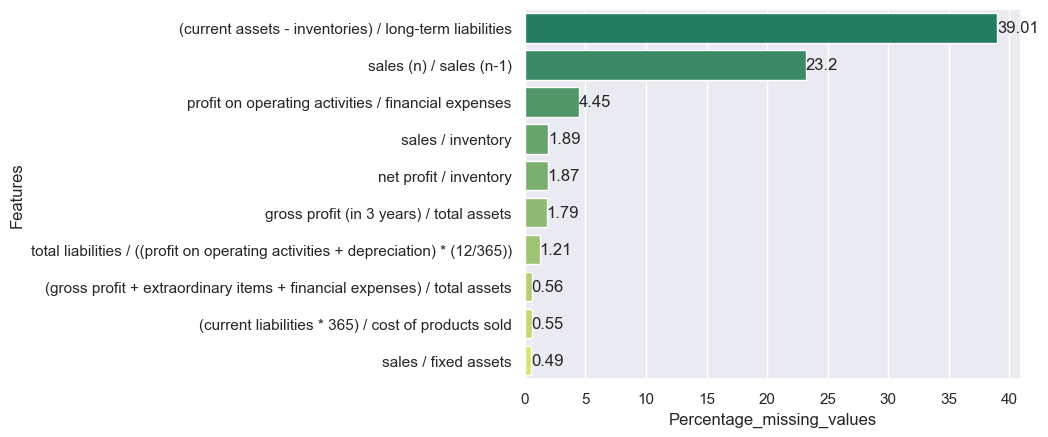

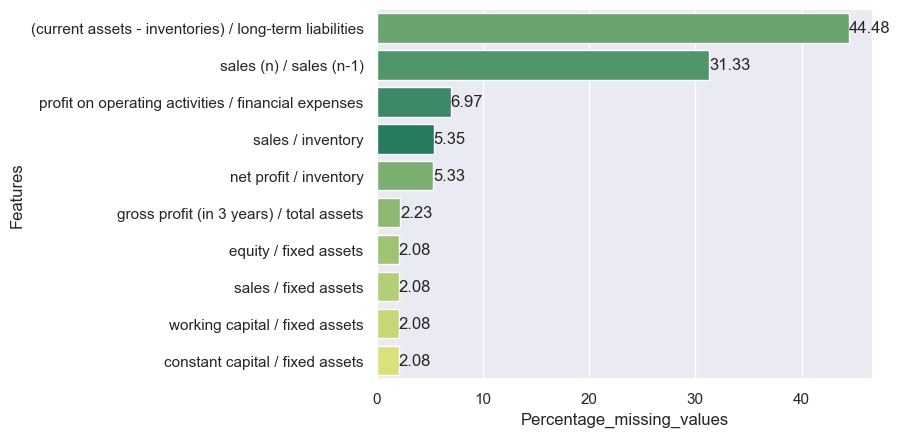

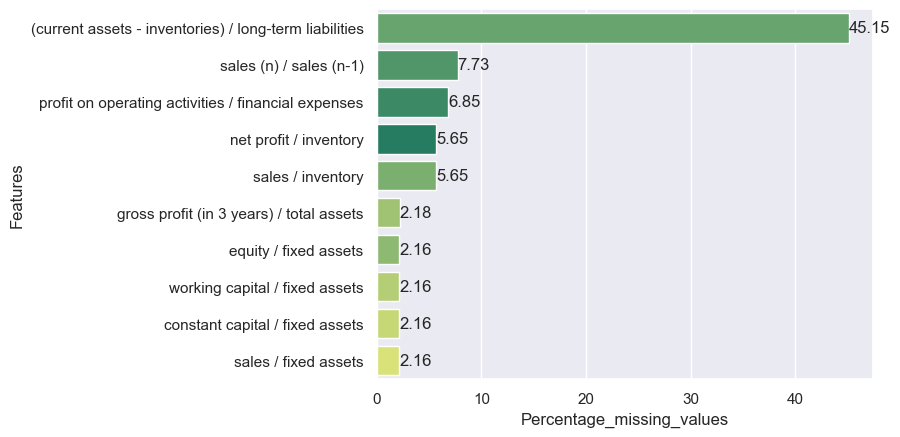

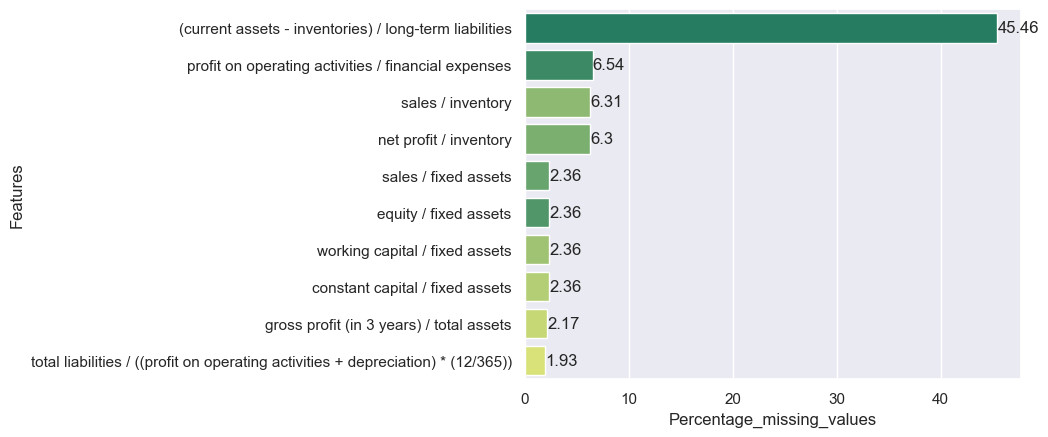

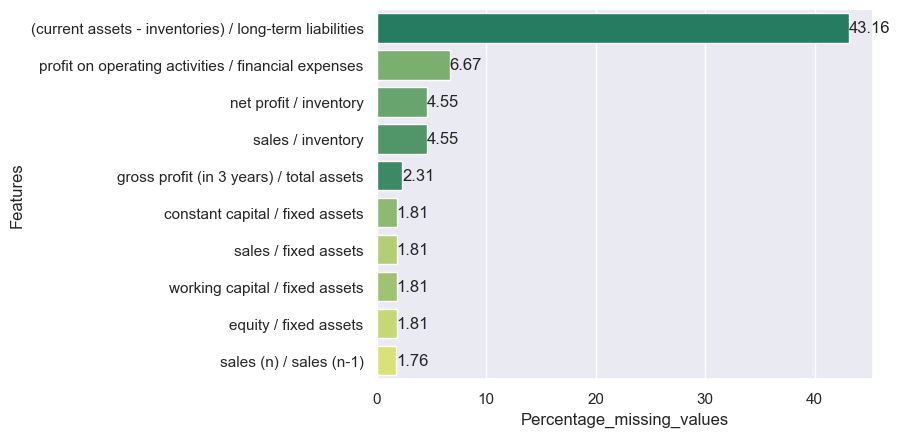

In [146]:
# Create table with missing value proportions for each dataset & plot results.
missing_year1 = analyze_missing_values(data_year_1)
missing_year2 = analyze_missing_values(data_year_2)
missing_year3 = analyze_missing_values(data_year_3)
missing_year4 = analyze_missing_values(data_year_4)
missing_year5 = analyze_missing_values(data_year_5)

<p>RESULT: Attribute 46 has a lot of missing values. Systematic or random missing values? To get some insights I tried to calculate attribute 46 by myself by deriving the individual values from formulas.
Note: Attribute 46 = (current assets - inventories) / long-term liabilities<p>

#### Apply function and calculate required features and finally attribute 46.


In [147]:
[calc_attr_46(df) for df in df_list]


Number of missing values before new calculation: 2709 \ Number of missing values after new calculation: 31
Number of missing values before new calculation: 4485 \ Number of missing values after new calculation: 24
Number of missing values before new calculation: 4703 \ Number of missing values after new calculation: 18
Number of missing values before new calculation: 4414 \ Number of missing values after new calculation: 44
Number of missing values before new calculation: 2525 \ Number of missing values after new calculation: 22


[None, None, None, None, None]

<p>Number of NA's was significatly smaller after new calculation: <br> before new calculation: 2709 <br> after new calculation: 31
<br> BUT: The NA's are now Inf's.
<br> The problem is the denominator long_term_liabilities which is zero, see output below.
<br> long_term_liabilities represent all  payables & obligations in a period of 12 months and longer. Therefore we can assume, that if "(current assets - inventories) / long-term liabilities" 
# is not available or equal to inf, that the company does not have long-term-liabilities. Therefore I will set attribute 46 to 0, where long_term_liabilities=0.
 <p>

In [148]:
# Check new columns (only the relevant)
data_year_1.loc[:, ["(current assets - inventories) / long-term liabilities new", "(current assets - inventories) / long-term liabilities", "long_term_liabilities"]].head(10)


,(current assets - inventories) / long-term liabilities new,(current assets - inventories) / long-term liabilities,long_term_liabilities
0,593.231544,348.0700,0.310183
1,inf,NaN,0.000000
2,2.302004,2.3019,16.782923
3,inf,NaN,0.000000
4,11.246743,11.2470,3.029942
5,22.312233,22.3120,0.873358
6,inf,NaN,0.000000
7,17.271519,50.4300,0.859918
8,2.753921,2.7538,40.056724
9,inf,NaN,0.000000


#### Replace NA's in "(current assets - inventories) / long-term liabilities" with zero where long_term_liabilities=0 and delete the columns that are no longer needed
<p> Note: Check if the columns have predicitve power later when the models are created.<p>

In [149]:
[replace_na_s_in_attr46(df) for df in df_list]


After replacing NA's: 
    (current assets - inventories) / long-term liabilities  \
0                                           348.0700        
1                                             0.0000        
2                                             2.3019        
3                                             0.0000        
4                                            11.2470        

   long_term_liabilities  
0               0.310183  
1               0.000000  
2              16.782923  
3               0.000000  
4               3.029942  
After replacing NA's: 
    (current assets - inventories) / long-term liabilities  \
0                                           354.3834        
1                                             0.0000        
2                                             0.0000        
3                                             1.9671        
4                                             0.0000        

   long_term_liabilities  
0               0.030088  
1 

[None, None, None, None, None]

#### Apply multivatiare feature imputation to each dataset to impute the remaining mussing values.


In [150]:
data_year_1_imp = multivariate_feature_imputation(data_year_1)
data_year_2_imp = multivariate_feature_imputation(data_year_2)
data_year_3_imp = multivariate_feature_imputation(data_year_3)
data_year_4_imp = multivariate_feature_imputation(data_year_4)
data_year_5_imp = multivariate_feature_imputation(data_year_5)

# create new dataframe list
df_list_imp= [  data_year_1_imp, 
                data_year_2_imp,
                data_year_3_imp,
                data_year_4_imp,
                data_year_5_imp]

[IterativeImputer] Early stopping criterion not reached.


# Feature Engineering
<p> # Solving the natural logarithm of 'logarithm of total assets' would help us to get "total assets" which would in turn help to calculate the following standalone metrics: <br> Equity, sales, EBIT, net profit, total liabilities, retained earnings, gross profit + interest, gross profit, profit on sales, total sales, constant capital, EBITDA, short-term liabilities.

<br>After checking the most crucial accounting ratios (e.g., the Debt-to-equity ratio), I concluded that the most important ratios are already included in the datasets.
Furthermore, it makes no sense to take the above mentioned metrics as standalone measures without a context to company size.
Therefore, no feature engineering is necessary in this analysis. <p>

# Multicollinearity
<p> Multicollinearity may not interfere with model performance, but it does negatively impact the interpretation of the predictors used to build the model. Therefore we need to tackle this issue.<p>

#### Drop iteratively columns with the highest VIF (Variance Inflation Factor) until the highest VIF is smaller than 8


In [151]:
# Print iterations only for the first year.
columns_to_keep_1_year = remove_cols_with_high_VIF(data_year_1_imp, print_values = True)
columns_to_keep_2_year = remove_cols_with_high_VIF(data_year_2_imp)
columns_to_keep_3_year = remove_cols_with_high_VIF(data_year_3_imp)
columns_to_keep_4_year = remove_cols_with_high_VIF(data_year_4_imp)
columns_to_keep_5_year = remove_cols_with_high_VIF(data_year_5_imp)

# Add Bankruptcy Dummy Variable
data_year_1_final = data_year_1_imp.loc[:,columns_to_keep_1_year.to_list() +  ["Bankruptcy Dummy"]]
data_year_2_final = data_year_2_imp.loc[:,columns_to_keep_2_year.to_list() +  ["Bankruptcy Dummy"]]
data_year_3_final = data_year_3_imp.loc[:,columns_to_keep_3_year.to_list() +  ["Bankruptcy Dummy"]]
data_year_4_final = data_year_4_imp.loc[:,columns_to_keep_4_year.to_list() +  ["Bankruptcy Dummy"]]
data_year_5_final = data_year_5_imp.loc[:,columns_to_keep_5_year.to_list() +  ["Bankruptcy Dummy"]]


divide by zero encountered in double_scalars


Feature EBIT / total assets has a VIF higher than 8 and will be dropped.


divide by zero encountered in double_scalars


Feature gross profit / total assets has a VIF higher than 8 and will be dropped.
Feature (current liabilities * 365) / cost of products sold has a VIF higher than 8 and will be dropped.
Feature (gross profit + depreciation) / total liabilities has a VIF higher than 8 and will be dropped.
Feature book value of equity / total liabilities has a VIF higher than 8 and will be dropped.
Feature gross profit / sales has a VIF higher than 8 and will be dropped.
Feature (gross profit + interest) / total assets has a VIF higher than 8 and will be dropped.
Feature constant capital / fixed assets has a VIF higher than 8 and will be dropped.
Feature profit on operating activities / total assets has a VIF higher than 8 and will be dropped.
Feature sales / short-term liabilities has a VIF higher than 8 and will be dropped.
Feature total liabilities / total assets has a VIF higher than 8 and will be dropped.
Feature rotation receivables + inventory turnover in days has a VIF higher than 8 and will be d

#### First step: find best model; Second step: Use best model for predictions
##### year 1 model

Best Threshold=0.281801, F-Score=0.507, Precision=0.649, Recall= 0.416
Model: XGBoost, AUC: 0.5047147529747364
Predictions overview: No bankruptcy: 2236 bankruptcy: 56
Accuracy: 96.82%
Best Threshold=0.143222, F-Score=0.473, Precision=0.462, Recall= 0.483
Model: XGBoost, AUC: 0.477244529527278
Predictions overview: No bankruptcy: 2200 bankruptcy: 92
Accuracy: 95.77%
Best Threshold=0.241601, F-Score=0.557, Precision=0.638, Recall= 0.494
Model: XGBoost, AUC: 0.5458519719249776
Predictions overview: No bankruptcy: 2224 bankruptcy: 68
Accuracy: 96.90%
Best Threshold=0.247338, F-Score=0.503, Precision=0.524, Recall= 0.483
Model: XGBoost, AUC: 0.4834639899366111
Predictions overview: No bankruptcy: 2211 bankruptcy: 81
Accuracy: 96.25%
Best Threshold=0.039275, F-Score=0.552, Precision=0.543, Recall= 0.562
Model: XGBoost, AUC: 0.5395978739226269
Predictions overview: No bankruptcy: 2201 bankruptcy: 91
Accuracy: 96.42%
Best Threshold=0.039275, F-Score=0.552, Precision=0.543, Recall= 0.562
Model

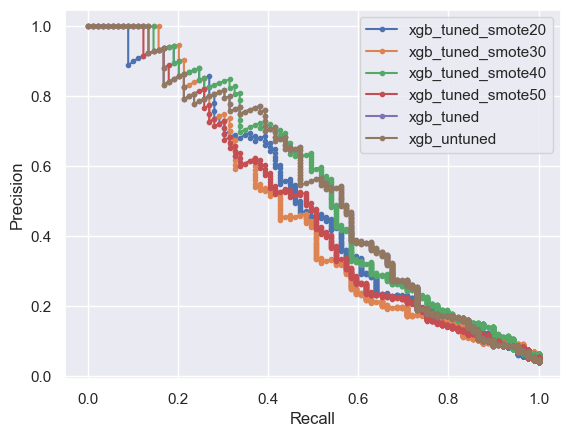

Best Threshold=0.241601, F-Score=0.557, Precision=0.638, Recall= 0.494
Model: XGBoost, AUC: 0.5458519719249776
Predictions overview: No bankruptcy: 2224 bankruptcy: 68
Accuracy: 96.90%


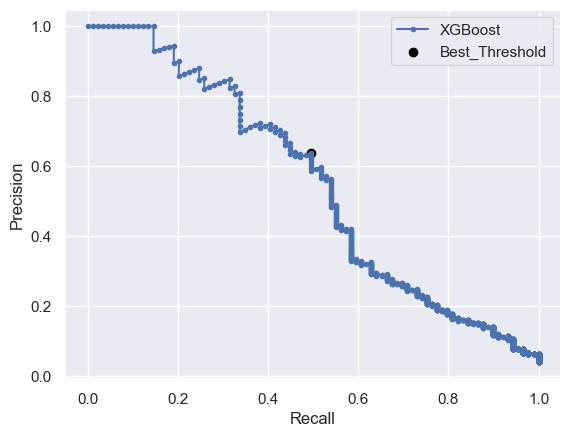

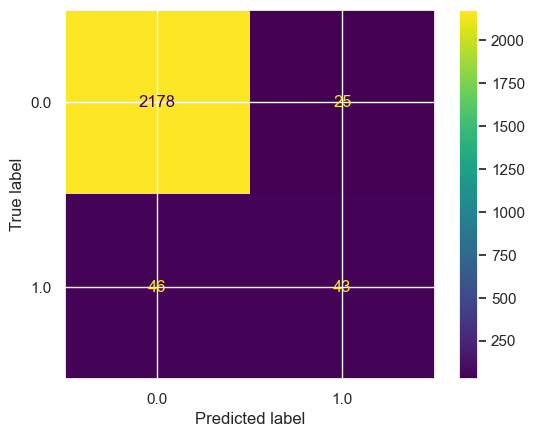

 92%|==================  | 2114/2292 [00:13<00:01]       Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


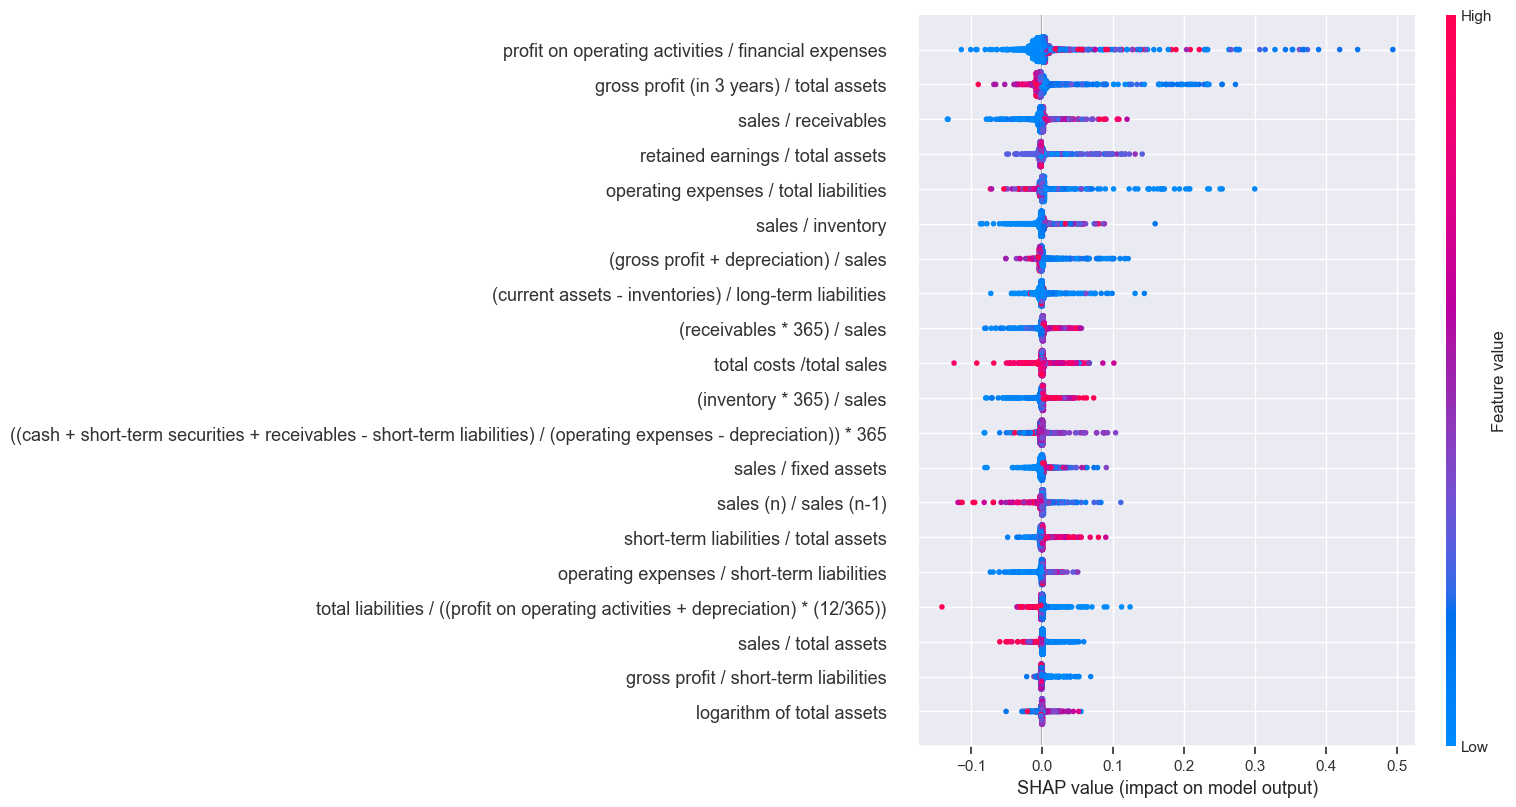

               Model  Precision    Recall  F1-Score
0  xgb_tuned_smote20   0.649123  0.415730  0.506849
1  xgb_tuned_smote30   0.462366  0.483146  0.472527
2  xgb_tuned_smote40   0.637681  0.494382  0.556962
3  xgb_tuned_smote50   0.524390  0.483146  0.502924
4          xgb_tuned   0.543478  0.561798  0.552486
Best performing model: xgb_tuned_smote40


In [152]:
# year1
metrics_year1, best_model_year1 = select_best_model(data_year_1_final)
create_model(df = data_year_1_final, Smote = True, sampling_prop= 0.40, plot_results = True, return_all = False, plot_shap_summary = True)

print(metrics_year1.head())
print(f"Best performing model: {best_model_year1}")

##### year 2 model

Best Threshold=0.134252, F-Score=0.432, Precision=0.438, Recall= 0.427
Model: XGBoost, AUC: 0.45055706653096494
Predictions overview: No bankruptcy: 3201 bankruptcy: 127
Accuracy: 95.55%
Best Threshold=0.349649, F-Score=0.442, Precision=0.558, Recall= 0.366
Model: XGBoost, AUC: 0.45535754697145664
Predictions overview: No bankruptcy: 3243 bankruptcy: 85
Accuracy: 96.33%
Best Threshold=0.764295, F-Score=0.415, Precision=0.731, Recall= 0.290
Model: XGBoost, AUC: 0.43209937499350304
Predictions overview: No bankruptcy: 3277 bankruptcy: 51
Accuracy: 96.75%
Best Threshold=0.337135, F-Score=0.415, Precision=0.443, Recall= 0.389
Model: XGBoost, AUC: 0.43256901389516245
Predictions overview: No bankruptcy: 3214 bankruptcy: 114
Accuracy: 95.64%
Best Threshold=0.076119, F-Score=0.473, Precision=0.584, Recall= 0.397
Model: XGBoost, AUC: 0.4685950028958052
Predictions overview: No bankruptcy: 3240 bankruptcy: 88
Accuracy: 96.48%
Best Threshold=0.076119, F-Score=0.473, Precision=0.584, Recall= 0.39

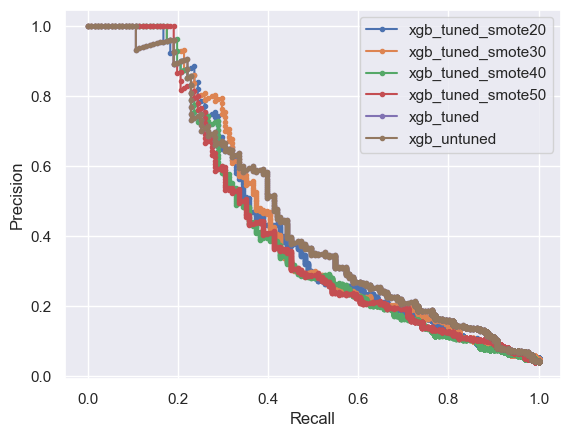

Best Threshold=0.076119, F-Score=0.473, Precision=0.584, Recall= 0.397
Model: XGBoost, AUC: 0.4685950028958052
Predictions overview: No bankruptcy: 3240 bankruptcy: 88
Accuracy: 96.48%


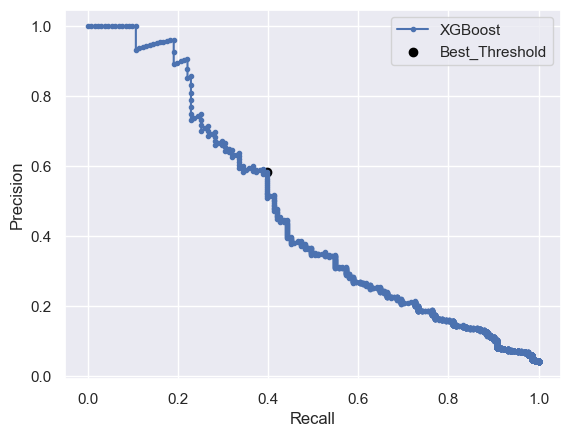

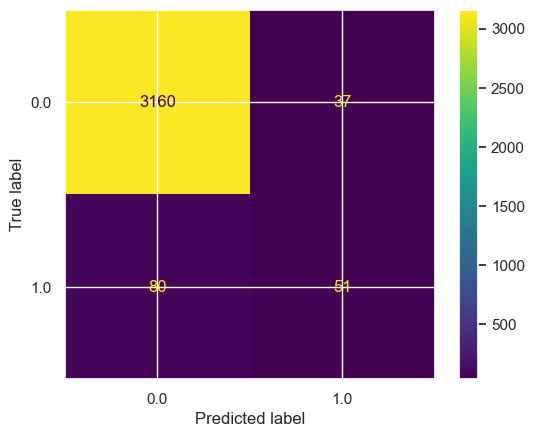

 93%|=================== | 3109/3328 [00:16<00:01]       Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


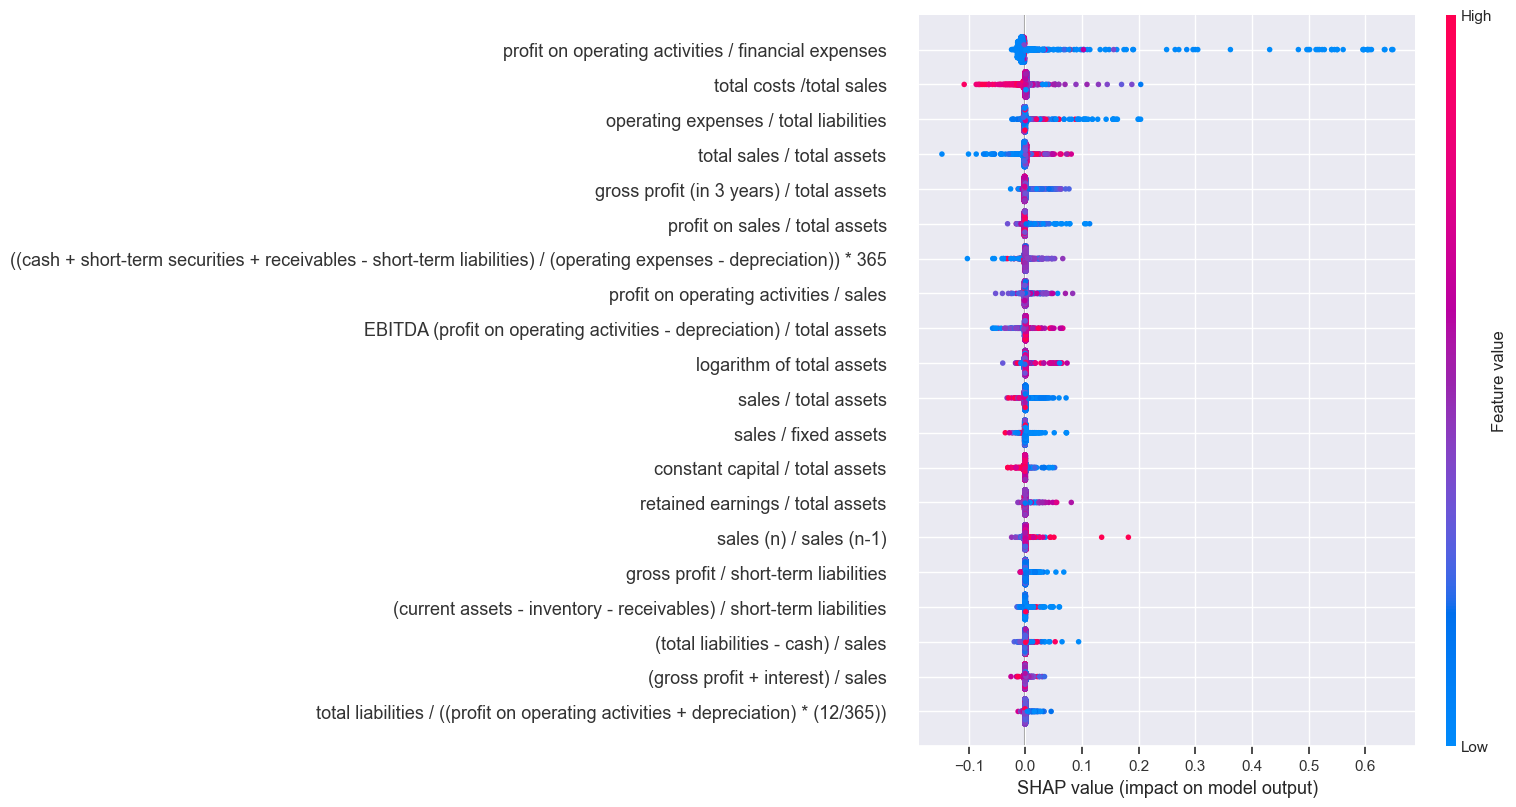

               Model  Precision    Recall  F1-Score
0  xgb_tuned_smote20   0.437500  0.427481  0.432432
1  xgb_tuned_smote30   0.558140  0.366412  0.442396
2  xgb_tuned_smote40   0.730769  0.290076  0.415301
3  xgb_tuned_smote50   0.443478  0.389313  0.414634
4          xgb_tuned   0.584270  0.396947  0.472727
Best performing model: xgb_tuned


In [153]:
# year2
metrics_year2, best_model_year2 = select_best_model(data_year_2_final)
create_model(df = data_year_2_final, Smote = False, plot_results = True, return_all = False, plot_shap_summary = True)

print(metrics_year2.head())
print(f"Best performing model: {best_model_year2}")

##### year 3 model

Best Threshold=0.292066, F-Score=0.491, Precision=0.623, Recall= 0.405
Model: XGBoost, AUC: 0.47120326802357293
Predictions overview: No bankruptcy: 3333 bankruptcy: 105
Accuracy: 95.99%
Best Threshold=0.408480, F-Score=0.481, Precision=0.607, Recall= 0.399
Model: XGBoost, AUC: 0.44866023127020754
Predictions overview: No bankruptcy: 3332 bankruptcy: 106
Accuracy: 95.90%
Best Threshold=0.740551, F-Score=0.464, Precision=0.743, Recall= 0.337
Model: XGBoost, AUC: 0.4569847193198336
Predictions overview: No bankruptcy: 3365 bankruptcy: 73
Accuracy: 96.28%
Best Threshold=0.638466, F-Score=0.461, Precision=0.634, Recall= 0.362
Model: XGBoost, AUC: 0.44836205906223486
Predictions overview: No bankruptcy: 3346 bankruptcy: 92
Accuracy: 95.96%
Best Threshold=0.122842, F-Score=0.489, Precision=0.631, Recall= 0.399
Model: XGBoost, AUC: 0.4777360024275718
Predictions overview: No bankruptcy: 3336 bankruptcy: 102
Accuracy: 96.02%
Best Threshold=0.122842, F-Score=0.489, Precision=0.631, Recall= 0.39

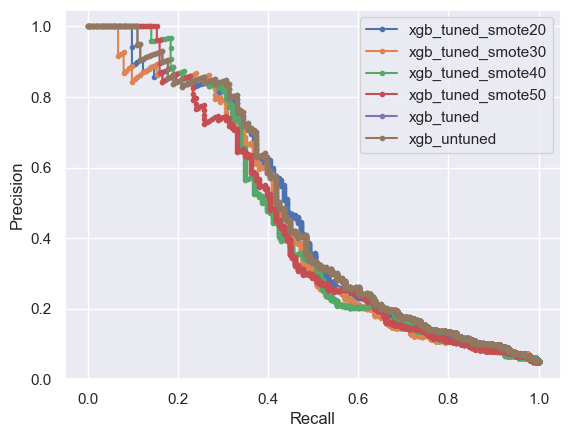

Best Threshold=0.292066, F-Score=0.491, Precision=0.623, Recall= 0.405
Model: XGBoost, AUC: 0.47120326802357293
Predictions overview: No bankruptcy: 3333 bankruptcy: 105
Accuracy: 95.99%


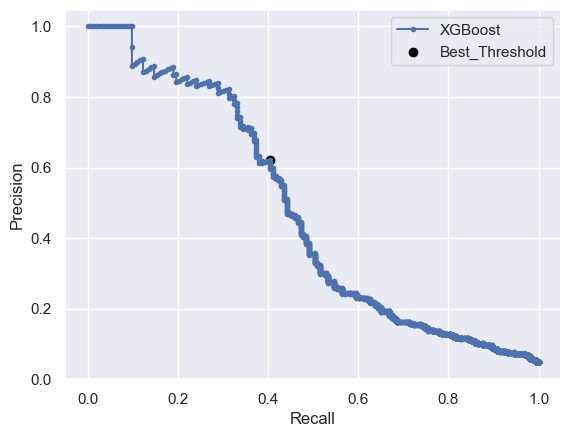

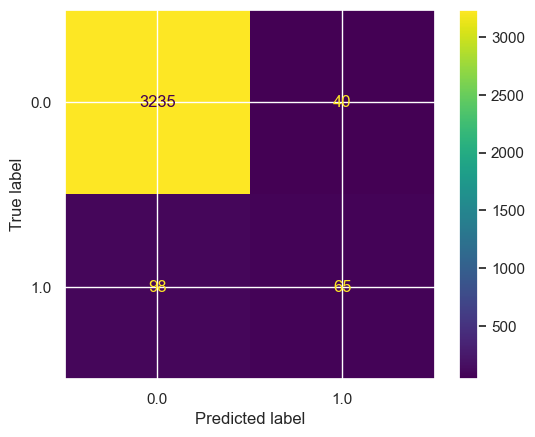

 97%|=================== | 3332/3438 [00:23<00:00]       Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


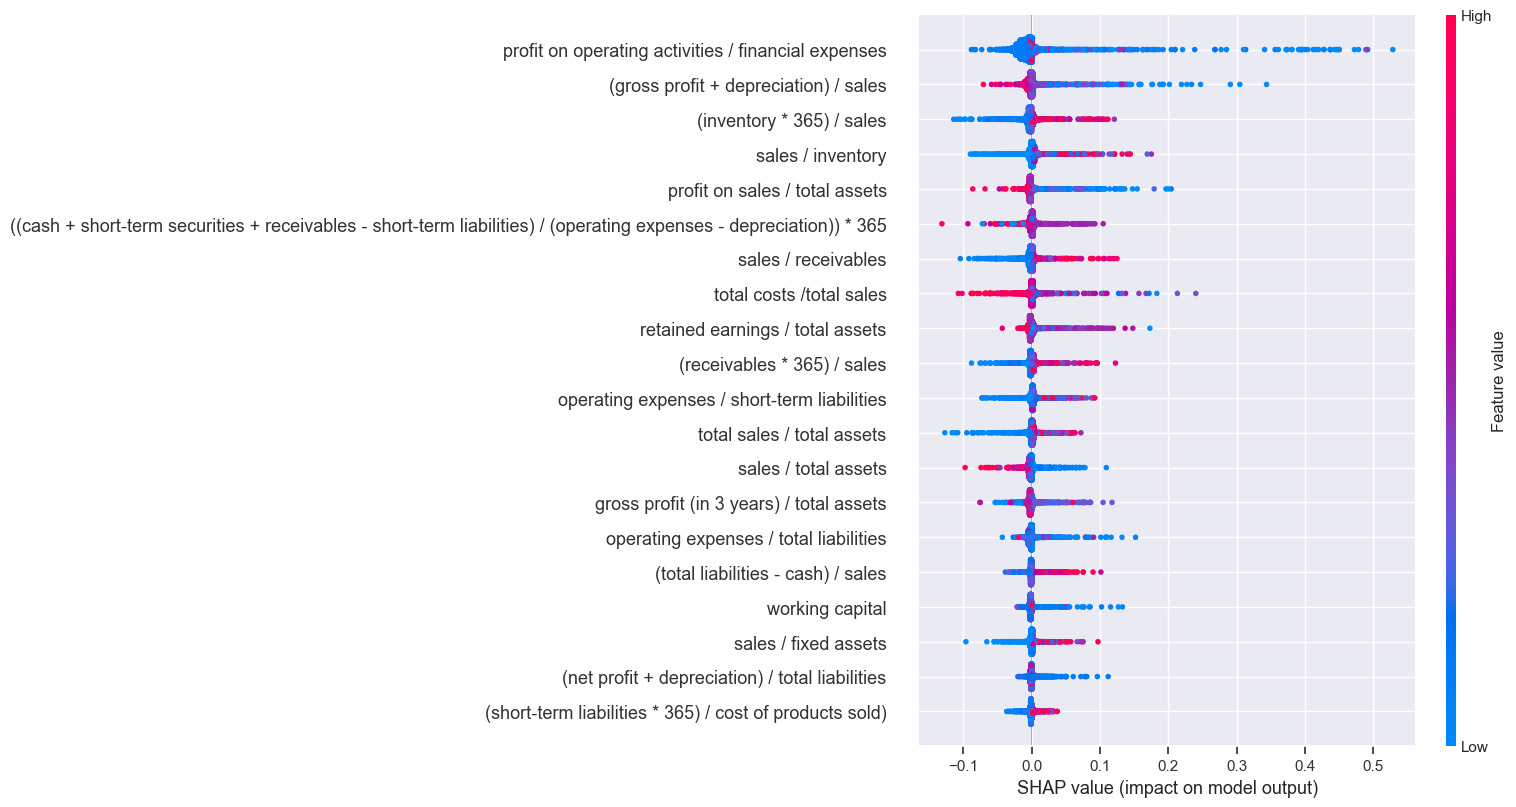

               Model  Precision    Recall  F1-Score
0  xgb_tuned_smote20   0.622642  0.404908  0.490706
1  xgb_tuned_smote30   0.607477  0.398773  0.481481
2  xgb_tuned_smote40   0.743243  0.337423  0.464135
3  xgb_tuned_smote50   0.634409  0.361963  0.460938
4          xgb_tuned   0.631068  0.398773  0.488722
Best performing model: xgb_tuned_smote20


In [154]:
# year3
metrics_year3, best_model_year3 = select_best_model(data_year_3_final)
create_model(df = data_year_3_final, Smote = True, sampling_prop= 0.20, plot_results = True, return_all = False, plot_shap_summary = True)

print(metrics_year3.head())
print(f"Best performing model: {best_model_year3}")

##### year 4 model

Best Threshold=0.206439, F-Score=0.497, Precision=0.564, Recall= 0.444
Model: XGBoost, AUC: 0.512822347584276
Predictions overview: No bankruptcy: 3073 bankruptcy: 132
Accuracy: 95.23%
Best Threshold=0.482485, F-Score=0.478, Precision=0.631, Recall= 0.385
Model: XGBoost, AUC: 0.5081217260666668
Predictions overview: No bankruptcy: 3103 bankruptcy: 102
Accuracy: 95.54%
Best Threshold=0.352570, F-Score=0.486, Precision=0.567, Recall= 0.426
Model: XGBoost, AUC: 0.5049250322686533
Predictions overview: No bankruptcy: 3079 bankruptcy: 126
Accuracy: 95.23%
Best Threshold=0.649551, F-Score=0.467, Precision=0.682, Recall= 0.355
Model: XGBoost, AUC: 0.49423390965890174
Predictions overview: No bankruptcy: 3118 bankruptcy: 87
Accuracy: 95.69%
Best Threshold=0.107664, F-Score=0.524, Precision=0.641, Recall= 0.444
Model: XGBoost, AUC: 0.5476576409867676
Predictions overview: No bankruptcy: 3089 bankruptcy: 116
Accuracy: 95.73%
Best Threshold=0.107664, F-Score=0.524, Precision=0.641, Recall= 0.444


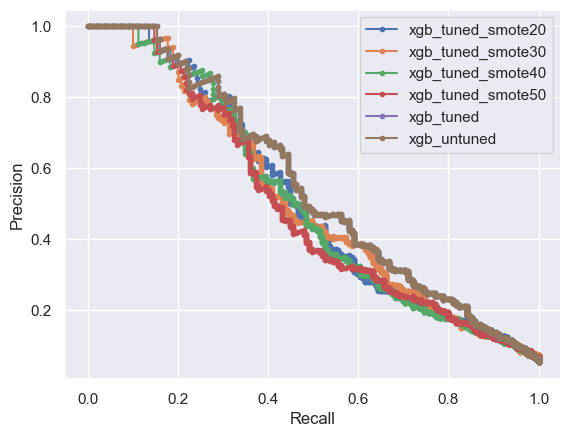

Best Threshold=0.107664, F-Score=0.524, Precision=0.641, Recall= 0.444
Model: XGBoost, AUC: 0.5476576409867676
Predictions overview: No bankruptcy: 3089 bankruptcy: 116
Accuracy: 95.73%


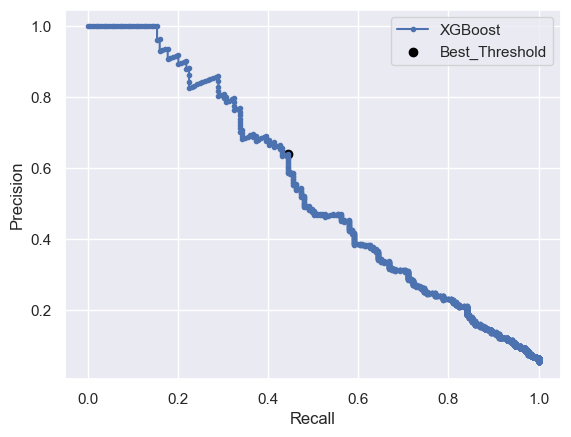

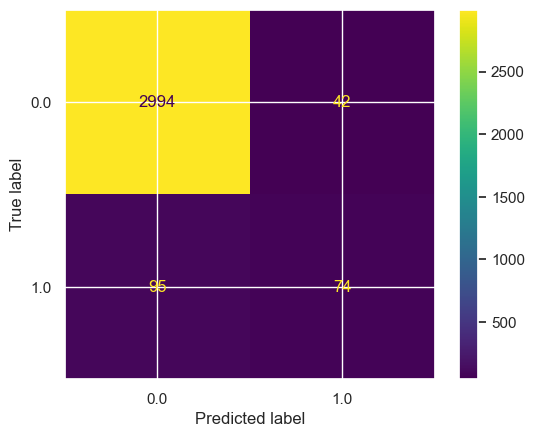

 97%|=================== | 3104/3205 [00:18<00:00]       Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


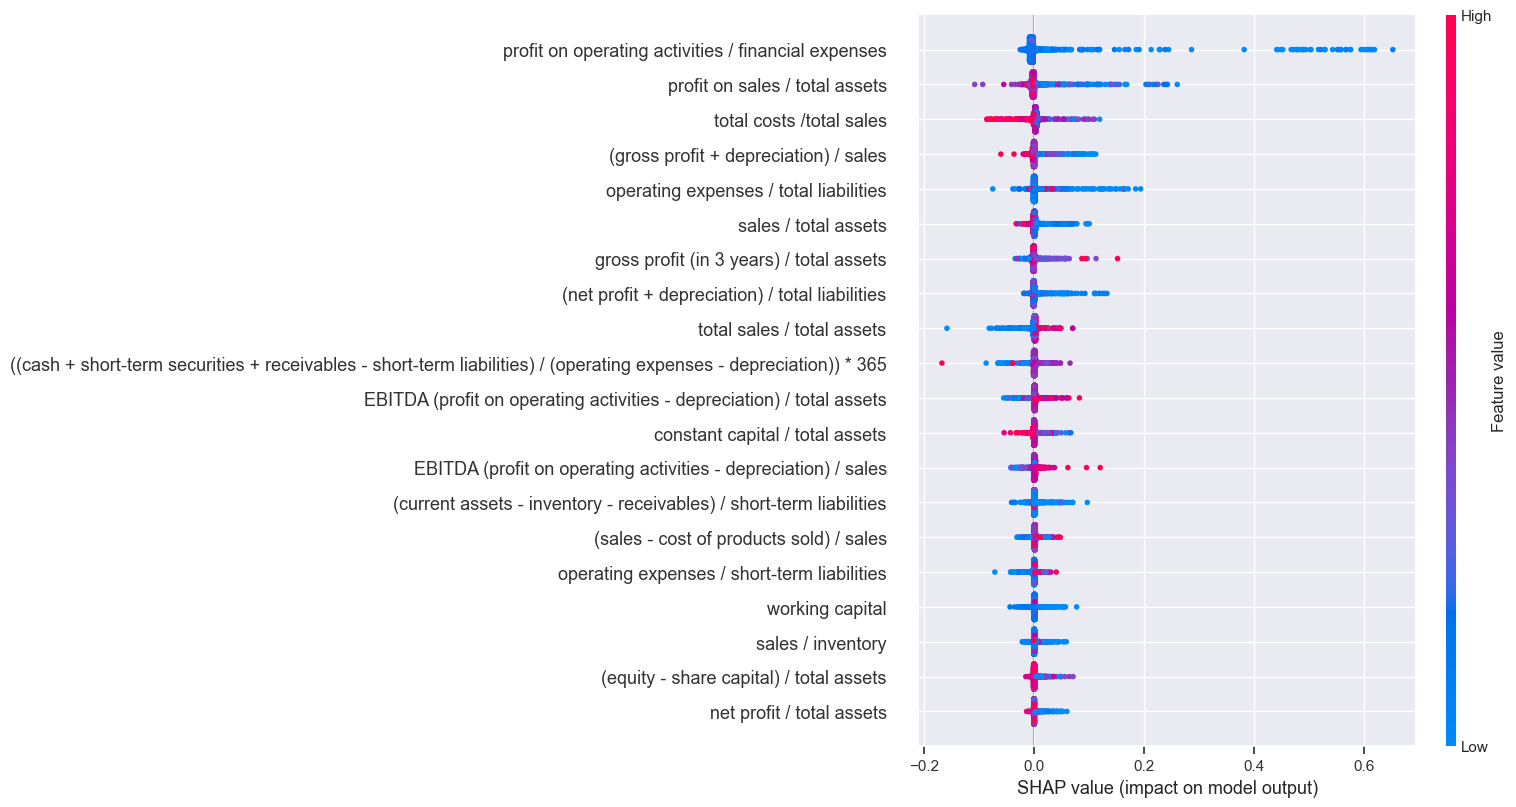

               Model  Precision    Recall  F1-Score
0  xgb_tuned_smote20   0.563910  0.443787  0.496689
1  xgb_tuned_smote30   0.631068  0.384615  0.477941
2  xgb_tuned_smote40   0.566929  0.426036  0.486486
3  xgb_tuned_smote50   0.681818  0.355030  0.466926
4          xgb_tuned   0.641026  0.443787  0.524476
Best performing model: xgb_tuned


In [155]:
# year4
metrics_year4, best_model_year4 = select_best_model(data_year_4_final)
create_model(df = data_year_4_final, Smote = False, plot_results = True, return_all = False, plot_shap_summary = True)

print(metrics_year4.head())
print(f"Best performing model: {best_model_year4}")

##### year 5 model

Best Threshold=0.270524, F-Score=0.522, Precision=0.526, Recall= 0.519
Model: XGBoost, AUC: 0.5769837247654788
Predictions overview: No bankruptcy: 1799 bankruptcy: 132
Accuracy: 93.32%
Best Threshold=0.644469, F-Score=0.543, Precision=0.649, Recall= 0.467
Model: XGBoost, AUC: 0.5829340396312908
Predictions overview: No bankruptcy: 1835 bankruptcy: 96
Accuracy: 94.46%
Best Threshold=0.546566, F-Score=0.528, Precision=0.563, Recall= 0.496
Model: XGBoost, AUC: 0.5804748820152978
Predictions overview: No bankruptcy: 1813 bankruptcy: 118
Accuracy: 93.73%
Best Threshold=0.825380, F-Score=0.516, Precision=0.663, Recall= 0.422
Model: XGBoost, AUC: 0.5749358614561012
Predictions overview: No bankruptcy: 1846 bankruptcy: 85
Accuracy: 94.41%
Best Threshold=0.250352, F-Score=0.538, Precision=0.588, Recall= 0.496
Model: XGBoost, AUC: 0.5993934290975592
Predictions overview: No bankruptcy: 1818 bankruptcy: 113
Accuracy: 93.99%
Best Threshold=0.250352, F-Score=0.538, Precision=0.588, Recall= 0.496
M

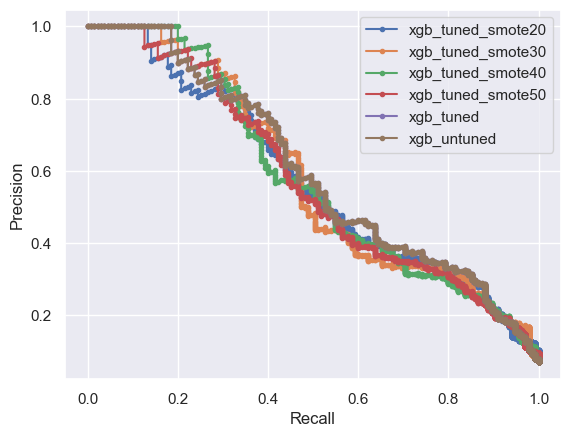

Best Threshold=0.644469, F-Score=0.543, Precision=0.649, Recall= 0.467
Model: XGBoost, AUC: 0.5829340396312908
Predictions overview: No bankruptcy: 1835 bankruptcy: 96
Accuracy: 94.46%


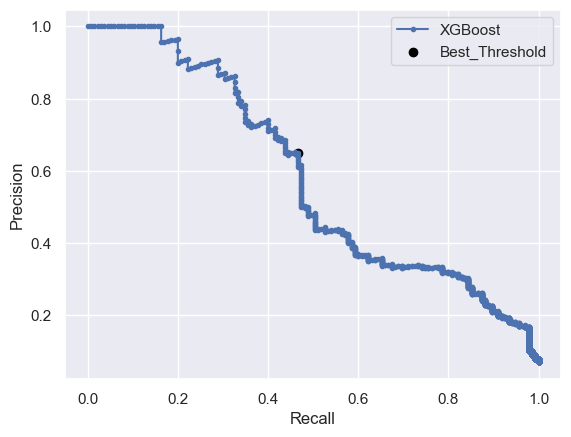

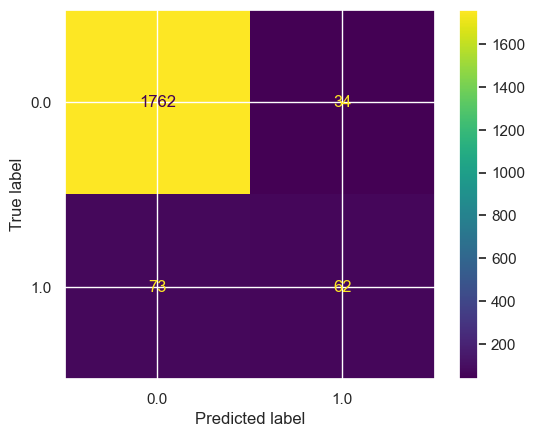

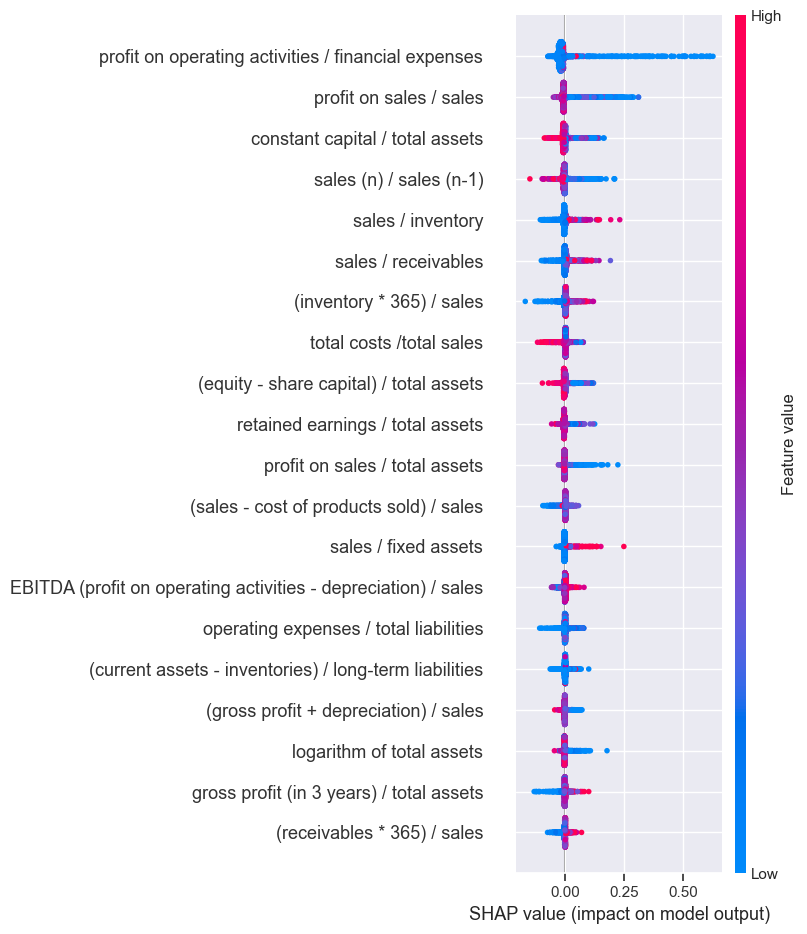

               Model  Precision    Recall  F1-Score
0  xgb_tuned_smote20   0.526316  0.518519  0.522388
1  xgb_tuned_smote30   0.649485  0.466667  0.543103
2  xgb_tuned_smote40   0.563025  0.496296  0.527559
3  xgb_tuned_smote50   0.662791  0.422222  0.515837
4          xgb_tuned   0.587719  0.496296  0.538153
Best performing model: xgb_tuned_smote30


In [156]:
# year5
metrics_year5, best_model_year5 = select_best_model(data_year_5_final)
create_model(df = data_year_5_final, Smote = True, sampling_prop= 0.30, plot_results = True, return_all = False, plot_shap_summary = True)

print(metrics_year5.head())
print(f"Best performing model: {best_model_year5}")